# Process bulk counts table

1. Annotate columns (samples) in a way that time point and replicate are annotated
2. Remove rRNA genes
3. Perform TPM normalization and alternatively also raw counts

In [1]:
# Use miniconda environment Jupyter_new for running this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tools import *
import warnings
warnings.filterwarnings('ignore')

## 1 Load the dataset and annotation

In [2]:
bulkPath = '../nf_output_1/countData/countData.tsv'
metaPath = '../Meaden[1]_SraRunTable.csv' # metadata from SRA
gffPath = '../nf_output_1/alignments/dualGenome.gff3' # output from nf pipeline

In [3]:
# Load data
df_initial = pd.read_csv(bulkPath, sep = '\t', comment='#', index_col=0)
metadata = pd.read_csv(metaPath)

In [4]:
df_initial.head()

,Chr,Start,End,Strand,Length,ERR3662886_sorted.bam,ERR3662906_sorted.bam,ERR3662884_sorted.bam,ERR3662917_sorted.bam,ERR3662899_sorted.bam,...,ERR3662921_sorted.bam,ERR3662909_sorted.bam,ERR3662915_sorted.bam,ERR3662882_sorted.bam,ERR3662894_sorted.bam,ERR3662881_sorted.bam,ERR3662919_sorted.bam,ERR3662903_sorted.bam,ERR3662889_sorted.bam,ERR3662902_sorted.bam
Geneid,,,,,,,,,,,,,,,,,,,,,
gene-R0792_RS00010,NZ_CP136842.1,199,372,-,174,5,6,12,11,11,...,5,6,8,17,8,7,2,5,4,17
gene-R0792_RS00015,NZ_CP136842.1,456,1244,-,789,9,9,18,20,21,...,14,9,13,23,13,9,6,17,13,26
gene-R0792_RS00020,NZ_CP136842.1,1566,2639,+,1074,682,1413,1480,1906,1110,...,1285,867,1513,1645,912,1015,804,1654,1631,2576
gene-R0792_RS00025,NZ_CP136842.1,2937,4355,+,1419,30,91,75,128,143,...,42,62,94,81,42,44,37,67,62,105
gene-R0792_RS00030,NZ_CP136842.1,4508,4891,+,384,357,524,763,734,831,...,396,678,650,862,730,1086,733,699,510,1433


## 2 Format the dataset

### 2.1 Annotate sample names

Issue now is that the metadata does not properly annotate sample names. Thus, this will be done manually by adding another sample name column to the metadata.

In [5]:
# Match GSM IDs and SampleNames inferred from GEO

sampleDict = {
    'SAMEA6168783': 'bim-phage-35_R1',
    'SAMEA6168784': 'bim-con-35_R4',
    'SAMEA6168785': 'wt-phage-35_R3',
    'SAMEA6168786': 'wt-phage-35_R4',
    'SAMEA6168787': 'bim-phage-60_R1',
    'SAMEA6168788': 'bim-phage-60_R2',
    'SAMEA6168789': 'bim-con-60_R1',
    'SAMEA6168790': 'bim-con-60_R2',
    'SAMEA6168791': 'wt-phage-60_R1',
    'SAMEA6168792': 'wt-phage-60_R2',
    'SAMEA6168793': 'bim-phage-60_R3',
    'SAMEA6168794': 'bim-con-35_R1',
    'SAMEA6168795': 'bim-phage-60_R4',
    'SAMEA6168796': 'bim-con-60_R3',
    'SAMEA6168797': 'bim-con-60_R4',
    'SAMEA6168798': 'wt-phage-60_R3',
    'SAMEA6168799': 'wt-phage-60_R4',
    'SAMEA6168800': 'bim-phage-120_R1',
    'SAMEA6168801': 'bim-phage-120_R2',
    'SAMEA6168802': 'bim-con-120_R1',
    'SAMEA6168803': 'bim-con-120_R2',
    'SAMEA6168804': 'wt-phage-120_R1',
    'SAMEA6168805': 'wt-phage-35_R1',
    'SAMEA6168806': 'wt-phage-120_R2',
    'SAMEA6168807': 'bim-phage-35_R5',
    'SAMEA6168808': 'bim-con-35_R5',
    'SAMEA6168809': 'bim-con-60_R5',
    'SAMEA6168810': 'bim-con-120_R3',
    'SAMEA6168811': 'bim-con-120_R4',
    'SAMEA6168812': 'bim-con-120_R5',
    'SAMEA6168813': 'wt-phage-35_R5',
    'SAMEA6168814': 'wt-phage-120_R5',
    'SAMEA6168815': 'wt-phage-120_R3',
    'SAMEA6168816': 'bim-phage-35_R2',
    'SAMEA6168817': 'wt-phage-120_R4',
    'SAMEA6168818': 'wt-phage-120_R6',
    'SAMEA6168819': 'bim-phage-60_R5',
    'SAMEA6168820': 'bim-phage-120_R3',
    'SAMEA6168821': 'bim-phage-120_R4',
    'SAMEA6168822': 'bim-phage-120_R5',
    'SAMEA6168823': 'bim-con-35_R2',
    'SAMEA6168824': 'wt-phage-35_R2',
    'SAMEA6168825': 'bim-phage-35_R3',
    'SAMEA6168826': 'bim-phage-35_R4',
    'SAMEA6168827': 'bim-con-35_R3'
}

# 

In [6]:
metadataFull = annotateData(metadata, sampleDict)

In [7]:
metadata.head(1)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,...,Organism,Platform,ReleaseDate,create_date,version,Sample Name,Sample_name,SRA Study,Submitter_Id,common_name
0,ERR3662878,RNA-Seq,271,1238110357,PRJEB31514,SAMEA6168783,421926880,UNIVERSITY OF EXETER,public,"fastq,run.zq,sra",...,Pseudomonas aeruginosa,ILLUMINA,2021-06-30T00:00:00Z,2021-07-21T01:39:00Z,1,SAMEA6168783,SM1,ERP114085,SM1,Pseudomonas aeruginosa


In [8]:
metadataFull.head()

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,...,ReleaseDate,create_date,version,Sample Name,Sample_name,SRA Study,Submitter_Id,common_name,SampleID,SampleNames
SampleID,,,,,,,,,,,,,,,,,,,,,
ERR3662878_sorted.bam,ERR3662878,RNA-Seq,271,1238110357,PRJEB31514,SAMEA6168783,421926880,UNIVERSITY OF EXETER,public,"fastq,run.zq,sra",...,2021-06-30T00:00:00Z,2021-07-21T01:39:00Z,1,SAMEA6168783,SM1,ERP114085,SM1,Pseudomonas aeruginosa,ERR3662878_sorted.bam,bim-phage-35_R1
ERR3662879_sorted.bam,ERR3662879,RNA-Seq,269,1659636862,PRJEB31514,SAMEA6168784,573146397,UNIVERSITY OF EXETER,public,"fastq,run.zq,sra",...,2021-06-30T00:00:00Z,2021-07-21T01:39:00Z,1,SAMEA6168784,SM10,ERP114085,SM10,Pseudomonas aeruginosa,ERR3662879_sorted.bam,bim-con-35_R4
ERR3662880_sorted.bam,ERR3662880,RNA-Seq,271,1404460424,PRJEB31514,SAMEA6168785,482335697,UNIVERSITY OF EXETER,public,"fastq,run.zq,sra",...,2021-06-30T00:00:00Z,2021-07-21T01:36:00Z,1,SAMEA6168785,SM11,ERP114085,SM11,Pseudomonas aeruginosa,ERR3662880_sorted.bam,wt-phage-35_R3
ERR3662881_sorted.bam,ERR3662881,RNA-Seq,272,1251664016,PRJEB31514,SAMEA6168786,430081701,UNIVERSITY OF EXETER,public,"fastq,run.zq,sra",...,2021-06-30T00:00:00Z,2021-07-21T01:35:00Z,1,SAMEA6168786,SM12,ERP114085,SM12,Pseudomonas aeruginosa,ERR3662881_sorted.bam,wt-phage-35_R4
ERR3662882_sorted.bam,ERR3662882,RNA-Seq,273,1442850885,PRJEB31514,SAMEA6168787,499252134,UNIVERSITY OF EXETER,public,"fastq,run.zq,sra",...,2021-06-30T00:00:00Z,2021-07-21T01:39:00Z,1,SAMEA6168787,SM13,ERP114085,SM13,Pseudomonas aeruginosa,ERR3662882_sorted.bam,bim-phage-60_R1


Add correct sample names.

In [9]:
samples = [

    # bim_phage
    # 'bim-phage-35_R1', 'bim-phage-35_R2', 'bim-phage-35_R3', 'bim-phage-35_R4', 'bim-phage-35_R5',
    # 'bim-phage-60_R1', 'bim-phage-60_R2', 'bim-phage-60_R3', 'bim-phage-60_R4', 'bim-phage-60_R5',
    # 'bim-phage-120_R1', 'bim-phage-120_R2', 'bim-phage-120_R3', 'bim-phage-120_R4', 'bim-phage-120_R5',

    # bim_con
    'bim-con-35_R1', 'bim-con-35_R2', 'bim-con-35_R3', 'bim-con-35_R4', 'bim-con-35_R5',
    'bim-con-60_R1', 'bim-con-60_R2', 'bim-con-60_R3', 'bim-con-60_R4', 'bim-con-60_R5',
    'bim-con-120_R1', 'bim-con-120_R2', 'bim-con-120_R3', 'bim-con-120_R4', 'bim-con-120_R5',

    # wt_phage
    # 'wt-phage-35_R1', 'wt-phage-35_R3', 'wt-phage-35_R4', 'wt-phage-35_R5',
    # 'wt-phage-60_R1', 'wt-phage-60_R2', 'wt-phage-60_R3', 'wt-phage-60_R4',
    # 'wt-phage-120_R1', 'wt-phage-120_R2', 'wt-phage-120_R3', 'wt-phage-120_R4'
]

df = changeColnames(df_initial.iloc[:,5:df_initial.shape[1]], metadataFull).drop(['wt-phage-120_R5', 'wt-phage-120_R6', 'wt-phage-35_R2'], axis=1)
df = df[samples]
df

SampleNames,bim-con-35_R1,bim-con-35_R2,bim-con-35_R3,bim-con-35_R4,bim-con-35_R5,bim-con-60_R1,bim-con-60_R2,bim-con-60_R3,bim-con-60_R4,bim-con-60_R5,bim-con-120_R1,bim-con-120_R2,bim-con-120_R3,bim-con-120_R4,bim-con-120_R5
Geneid,,,,,,,,,,,,,,,
gene-R0792_RS00010,4,10,12,13,5,12,19,13,15,5,11,13,6,6,5
gene-R0792_RS00015,13,22,12,15,17,18,29,23,20,10,22,18,11,9,21
gene-R0792_RS00020,1631,1675,1597,1863,1654,1480,1927,1686,1225,845,1421,1402,1399,1413,1384
gene-R0792_RS00025,62,78,49,85,67,75,101,78,59,27,86,65,57,91,67
gene-R0792_RS00030,510,759,493,742,699,763,853,989,627,262,691,637,497,524,593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-DMS3-48,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
gene-DMS3-49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
gene-DMS3-50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 2.2 Remove rRNA genes

Consult gff3 file to get rRNA geneids.

In [10]:
# Load gff3 and split into genes and CDS dfs
gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3.columns=["seq_id", "source", "type", "start", "end", "phase", "strand", "score", "attributes"]
gff3_genes = gff3.loc[gff3["type"] == 'gene']

# Column formating for genes
gff3_genes = gff3_genes.reset_index(drop=True)
dct_genes = gff3_genes["attributes"].str.split(';').apply(lambda items: dict(item.split('=', 1) for item in items if '=' in item))
cols_to_keep = ['ID', 'Name', 'gbkey', 'gene_biotype', 'locus_tag', 'gene']
gff3_genes = pd.concat([gff3_genes, pd.json_normalize(dct_genes)[cols_to_keep]], axis=1)

# Generate locus_tag, product dictonary over all different feature types
attrs = gff3["attributes"].str.split(";", expand=True)
attrs_dicts = attrs.apply(lambda row: {item.split("=")[0]: item.split("=")[1] for item in row if "=" in str(item)}, axis=1)
attrs_df = pd.json_normalize(attrs_dicts)
attrs_df = attrs_df.dropna(subset=["locus_tag", "product"])
locus_product_dict = dict(zip(attrs_df["locus_tag"], attrs_df["product"]))

# Add gene product, if not stated in gff3, fill with gene_biotype
gff3_genes["product"] = gff3_genes["locus_tag"].map(locus_product_dict)
# gff3_genes["product"] = gff3_genes["product"].fillna("other")
gff3_genes["product"] = gff3_genes["product"].fillna(gff3_genes["gene_biotype"])

# If gene = NA, take from ID column
gff3_genes["gene"] = gff3_genes["gene"].fillna(gff3_genes["ID"])

# Drop attributes column
gff3_genes = gff3_genes.drop(["attributes"], axis=1)

In [11]:
pharokka_path = "../../../2025-12_reannotation_phage_genomes/Pharokka_proteins_phages_out/NC_008717.1_out/pharokka_proteins_full_merged_output.tsv"
gff3_genes = add_pharokka(gff3_genes, pharokka_path)
gff3_genes.loc[gff3_genes['seq_id'] == "NC_008717.1"]

,seq_id,source,type,start,end,phase,strand,score,ID,Name,gbkey,gene_biotype,locus_tag,gene,product,annot,PHROG,category
5971,NC_008717.1,RefSeq,gene,170.0,880.0,.,-,.,gene-DMS3-1,DMS3-1,Gene,protein_coding,DMS3-1,gene-DMS3-1,transcriptional repressor,transcriptional repressor,4.0,transcription regulation
5972,NC_008717.1,RefSeq,gene,1428.0,1862.0,.,+,.,gene-DMS3-2,DMS3-2,Gene,protein_coding,DMS3-2,gene-DMS3-2,transcriptional regulator,transcriptional regulator,2345.0,transcription regulation
5973,NC_008717.1,RefSeq,gene,1862.0,2071.0,.,+,.,gene-DMS3-3,DMS3-3,Gene,protein_coding,DMS3-3,gene-DMS3-3,hypothetical protein,hypothetical protein,4468.0,unknown function
5974,NC_008717.1,RefSeq,gene,2175.0,4136.0,.,+,.,gene-DMS3-4,DMS3-4,Gene,protein_coding,DMS3-4,gene-DMS3-4,transposase,transposase,310.0,integration and excision
5975,NC_008717.1,RefSeq,gene,4151.0,4903.0,.,+,.,gene-DMS3-5,DMS3-5,Gene,protein_coding,DMS3-5,gene-DMS3-5,DNA transposition protein,DNA transposition protein,296.0,integration and excision
5976,NC_008717.1,RefSeq,gene,4900.0,5565.0,.,+,.,gene-DMS3-6,DMS3-6,Gene,protein_coding,DMS3-6,gene-DMS3-6,transcriptional regulator,transcriptional regulator,2030.0,transcription regulation
5977,NC_008717.1,RefSeq,gene,5637.0,6272.0,.,+,.,gene-DMS3-7,DMS3-7,Gene,protein_coding,DMS3-7,gene-DMS3-7,hypothetical protein,hypothetical protein,3190.0,unknown function
5978,NC_008717.1,RefSeq,gene,6257.0,6373.0,.,+,.,gene-DMS3-8,DMS3-8,Gene,protein_coding,DMS3-8,gene-DMS3-8,hypothetical protein,hypothetical protein,3765.0,unknown function
5979,NC_008717.1,RefSeq,gene,6373.0,6786.0,.,+,.,gene-DMS3-9,DMS3-9,Gene,protein_coding,DMS3-9,gene-DMS3-9,hypothetical protein,hypothetical protein,2119.0,unknown function
5980,NC_008717.1,RefSeq,gene,6788.0,7060.0,.,+,.,gene-DMS3-10,DMS3-10,Gene,protein_coding,DMS3-10,gene-DMS3-10,hypothetical protein,hypothetical protein,2043.0,unknown function


In [12]:
# Load ggf3 file

gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3 = gff3.loc[gff3.iloc[:,2] == 'gene']

# Format some new columns
gff3['ID'] = pd.DataFrame(gff3.iloc[:,8].str.split('ID=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['GeneType'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene_biotype=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['Symbol'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]

# Add entity host and phage
gff3['Entity'] = np.where(gff3[0] == 'NC_008717.1', 'phage', 'host')
gff3.index = gff3['ID']
rRNAs = gff3.loc[gff3['GeneType'] == 'rRNA', 'ID'].tolist()

Perform in silico rRNA depletion.

In [13]:
df_norRNAs = rRNAdepletion(df,rRNAs)
df_norRNAs

SampleNames,bim-con-35_R1,bim-con-35_R2,bim-con-35_R3,bim-con-35_R4,bim-con-35_R5,bim-con-60_R1,bim-con-60_R2,bim-con-60_R3,bim-con-60_R4,bim-con-60_R5,bim-con-120_R1,bim-con-120_R2,bim-con-120_R3,bim-con-120_R4,bim-con-120_R5
Geneid,,,,,,,,,,,,,,,
gene-R0792_RS04345,23,58,22,35,36,50,51,122,47,13,45,36,17,40,41
gene-DMS3-38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
gene-R0792_RS10210,43,57,38,61,41,29,60,50,47,17,22,23,30,23,26
gene-R0792_RS13665,10002,10469,9787,10330,8849,9148,13885,8867,7450,6384,6985,5899,6806,6003,5362
gene-R0792_RS08925,6,12,9,13,19,13,19,13,11,9,15,11,7,11,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-R0792_RS28815,33,59,37,26,43,44,56,92,33,14,51,55,34,29,29
gene-R0792_RS10985,38,82,34,60,52,88,108,110,74,30,92,76,46,43,63
gene-R0792_RS00420,290,280,222,301,260,274,381,331,267,159,253,205,229,192,215


### 2.3 Read count normalization

Important note: gene symbols not available for most genes.

In [14]:
# Function to fill in missing symbols by geneid.

def fillSymbols(df):
    df_new = df.copy()
    index = df.index.to_list()
    for i in range(0,df.shape[0]):
        if (df.iloc[i,-1:].values == None):
            df_new.iloc[i,-1:] = index[i]
    return df_new

Convert counts to TPM.

In [15]:
tpms = TPM(df_norRNAs, df_initial, 0.5)
tpms['Entity'] = gff3.loc[sorted(tpms.index.to_list()), 'Entity']
tpms['Symbol'] = gff3.loc[sorted(tpms.index.to_list()), 'Symbol']

tpms = fillSymbols(tpms)
tpms = make_unique_with_index(tpms)
tpms

SampleNames,bim-con-35_R1,bim-con-35_R2,bim-con-35_R3,bim-con-35_R4,bim-con-35_R5,bim-con-60_R1,bim-con-60_R2,bim-con-60_R3,bim-con-60_R4,bim-con-60_R5,bim-con-120_R1,bim-con-120_R2,bim-con-120_R3,bim-con-120_R4,bim-con-120_R5,Entity,Symbol
Geneid,,,,,,,,,,,,,,,,,
gene-R0792_RS04345,1.684588,5.134390,1.782951,2.613898,3.463877,4.046695,2.837754,11.741432,4.973059,1.371085,4.614483,4.294239,1.577816,4.121645,5.108610,host,gene-R0792_RS04345
gene-DMS3-38,0.178017,0.217956,0.196785,0.182850,0.235670,0.198996,0.136837,0.238024,0.259995,0.252212,0.251853,0.292165,0.223900,0.252726,0.305696,phage,gene-DMS3-38
gene-R0792_RS10210,6.278700,10.161442,6.142882,9.117799,7.929983,4.759766,6.712395,9.746101,10.013321,3.578684,4.594611,5.566930,5.536978,4.815462,6.568331,host,gene-R0792_RS10210
gene-R0792_RS13665,1960.307752,2512.167860,2120.403298,2079.559963,2296.032824,2004.235365,2091.793744,2323.677945,2132.579241,1772.749562,1936.862993,1897.572419,1677.768583,1670.359029,1804.727723,host,amrZ
gene-R0792_RS08925,1.983616,4.670476,3.204784,4.231675,7.878117,4.605333,4.574255,5.508546,5.125616,4.107453,6.692087,5.759827,2.878710,4.982320,4.978476,host,gene-R0792_RS08925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-R0792_RS28815,1.923730,4.183341,2.380463,1.563074,3.306985,2.856554,2.493959,7.102317,2.809623,1.179701,4.184005,5.230699,2.491787,2.404977,2.909042,host,gene-R0792_RS28815
gene-R0792_RS10985,3.225245,8.461804,3.194862,5.205852,5.822439,8.287593,6.986721,12.377226,9.115119,3.619984,10.963001,10.517945,4.899452,5.173458,9.134913,host,sbrR
gene-R0792_RS00420,73.007824,86.310404,61.813635,77.829635,86.671170,77.116756,73.698636,111.395037,98.186350,56.792208,90.133646,84.762265,72.543494,68.682109,93.003487,host,gene-R0792_RS00420


In [16]:
# Check gene names unique
len(tpms['Symbol'].unique())

6011

Log2+1 normalization tpms

In [17]:
logTPMs = logNorm(tpms.iloc[:, :-2])
logTPMs = logTPMs.join(tpms.iloc[:, -2:])
logTPMs = fillSymbols(logTPMs)
# Make gene names unique
logTPMs = make_unique_with_index(logTPMs)
logTPMs

SampleNames,bim-con-35_R1,bim-con-35_R2,bim-con-35_R3,bim-con-35_R4,bim-con-35_R5,bim-con-60_R1,bim-con-60_R2,bim-con-60_R3,bim-con-60_R4,bim-con-60_R5,bim-con-120_R1,bim-con-120_R2,bim-con-120_R3,bim-con-120_R4,bim-con-120_R5,Entity,Symbol
Geneid,,,,,,,,,,,,,,,,,
gene-R0792_RS04345,1.424701,2.616920,1.476616,1.853556,2.158297,2.335339,1.940262,3.671456,2.578470,1.245548,2.489153,2.404423,1.366150,2.356607,2.610844,host,gene-R0792_RS04345
gene-DMS3-38,0.236360,0.284462,0.259164,0.242267,0.305294,0.261827,0.185025,0.308039,0.333418,0.324479,0.324065,0.369790,0.291485,0.325071,0.384819,phage,gene-DMS3-38
gene-R0792_RS10210,2.863681,3.480452,2.836506,3.338824,3.158657,2.526010,2.947179,3.425741,3.461178,2.194933,2.484038,2.715219,2.708624,2.539894,2.919975,host,gene-R0792_RS10210
gene-R0792_RS13665,10.937600,11.295291,11.050803,11.022756,11.165556,10.969556,11.031214,11.182815,11.059060,10.792587,10.920251,10.890699,10.713188,10.706806,10.818365,host,amrZ
gene-R0792_RS08925,1.577062,2.503470,2.072032,2.387273,3.150254,2.486800,2.478779,2.702335,2.614855,2.352604,2.943375,2.756986,1.955577,2.580705,2.579778,host,gene-R0792_RS08925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-R0792_RS28815,1.547810,2.373882,1.757221,1.357875,2.106678,1.947312,1.804863,3.018334,1.929648,1.124130,2.374067,2.639394,1.803965,1.767645,1.966815,host,gene-R0792_RS28815
gene-R0792_RS10985,2.079035,3.242115,2.068623,2.633629,2.770288,3.215305,2.997603,3.741707,3.338441,2.207888,3.580507,3.525811,2.560581,2.626079,3.341262,host,sbrR
gene-R0792_RS00420,6.209606,6.448082,5.973006,6.300666,6.454031,6.287560,6.223010,6.812435,6.632070,5.852803,6.509912,6.422271,6.200526,6.122716,6.554642,host,gene-R0792_RS00420


## 3 Filter samples, if necessary: WT_Phage

Look for outliers visually by PCA.

In [18]:
columnOrder = ['bim-con-35_R1', 'bim-con-35_R2', 'bim-con-35_R3', 'bim-con-35_R4', 'bim-con-35_R5',
               'bim-con-60_R1', 'bim-con-60_R2', 'bim-con-60_R3', 'bim-con-60_R4', 'bim-con-60_R5',
               'bim-con-120_R1', 'bim-con-120_R2', 'bim-con-120_R3', 'bim-con-120_R4', 'bim-con-120_R5']

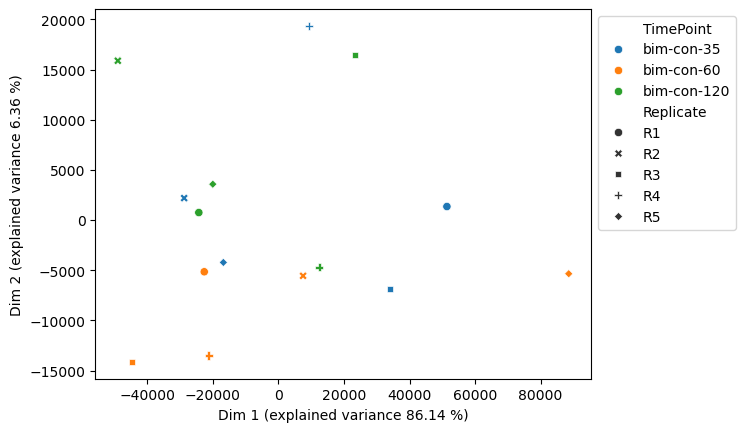

In [19]:
txPCA(tpms[columnOrder])

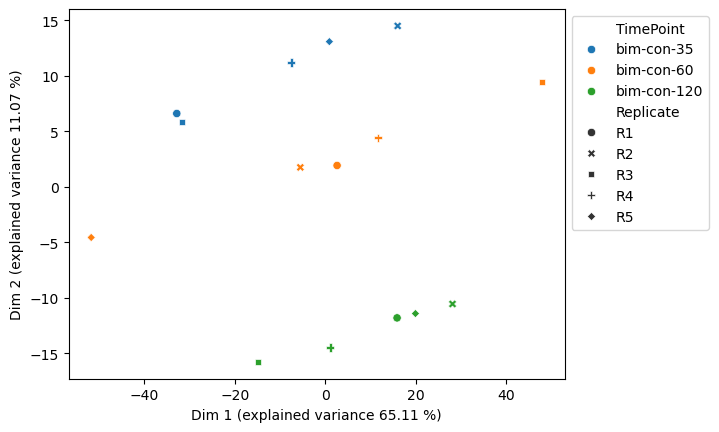

In [20]:
txPCA(logTPMs[columnOrder])

In [21]:
tpmHost = tpms[tpms['Entity'] == 'host']
tpmPhage = tpms[tpms['Entity'] == 'phage']
logTPMsHost = logTPMs[logTPMs['Entity'] == 'host']
logTPMsPhage = logTPMs[logTPMs['Entity'] == 'phage']

tpmHost

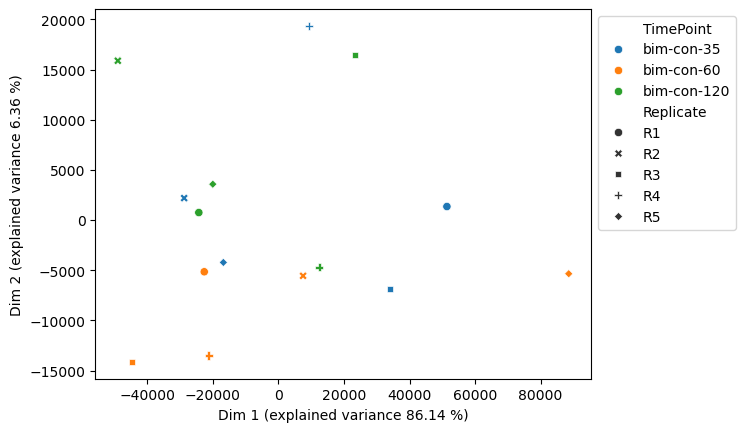

In [22]:
txPCA(tpmHost[columnOrder])

tpmPhage

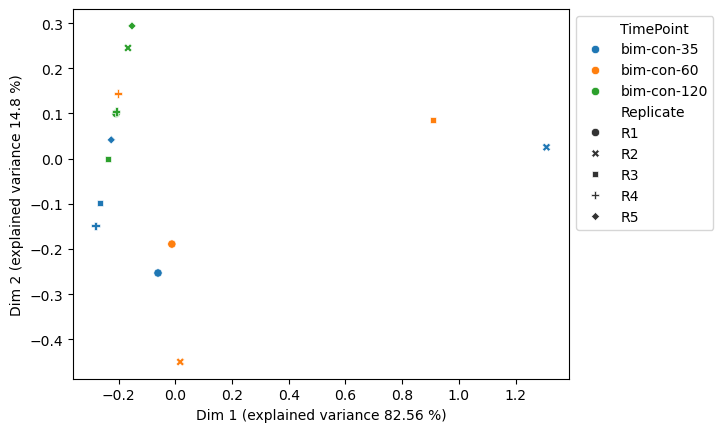

In [23]:
txPCA(tpmPhage[columnOrder])

logTPM Host

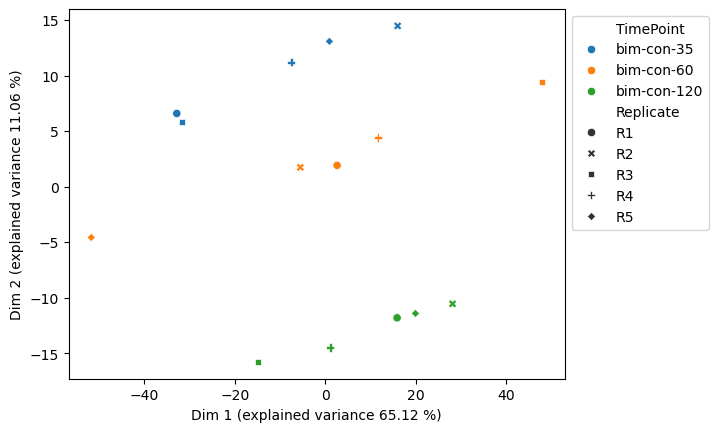

In [24]:
txPCA(logTPMsHost[columnOrder])

logTPM Phage

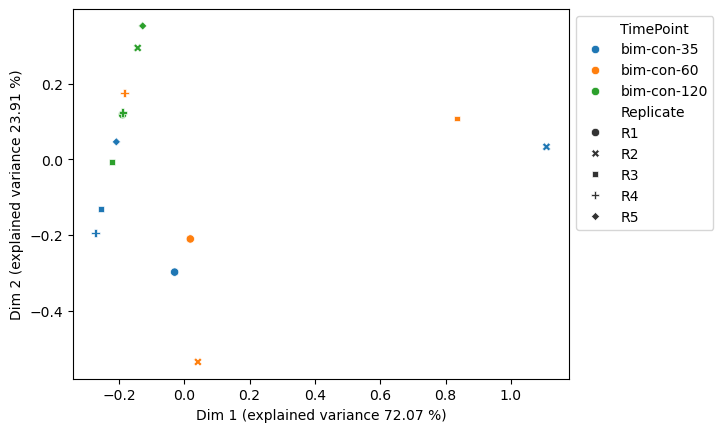

In [25]:
txPCA(logTPMsPhage[columnOrder])

$\rightarrow$ Log normalized values look fine, so everything is kept. Phage PCAs bit scattered, expected, since not phage expression expected, with exception of very low artifacts.

## 4. Final grouping

Summarize time points with mean and standard deviation for TPM-normalized data.

In [26]:
tpms.columns = tpms.columns.str.replace('bim-con-', '')

In [27]:
tpms

SampleNames,35_R1,35_R2,35_R3,35_R4,35_R5,60_R1,60_R2,60_R3,60_R4,60_R5,120_R1,120_R2,120_R3,120_R4,120_R5,Entity,Symbol
Geneid,,,,,,,,,,,,,,,,,
gene-R0792_RS04345,1.684588,5.134390,1.782951,2.613898,3.463877,4.046695,2.837754,11.741432,4.973059,1.371085,4.614483,4.294239,1.577816,4.121645,5.108610,host,gene-R0792_RS04345
gene-DMS3-38,0.178017,0.217956,0.196785,0.182850,0.235670,0.198996,0.136837,0.238024,0.259995,0.252212,0.251853,0.292165,0.223900,0.252726,0.305696,phage,gene-DMS3-38
gene-R0792_RS10210,6.278700,10.161442,6.142882,9.117799,7.929983,4.759766,6.712395,9.746101,10.013321,3.578684,4.594611,5.566930,5.536978,4.815462,6.568331,host,gene-R0792_RS10210
gene-R0792_RS13665,1960.307752,2512.167860,2120.403298,2079.559963,2296.032824,2004.235365,2091.793744,2323.677945,2132.579241,1772.749562,1936.862993,1897.572419,1677.768583,1670.359029,1804.727723,host,amrZ
gene-R0792_RS08925,1.983616,4.670476,3.204784,4.231675,7.878117,4.605333,4.574255,5.508546,5.125616,4.107453,6.692087,5.759827,2.878710,4.982320,4.978476,host,gene-R0792_RS08925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-R0792_RS28815,1.923730,4.183341,2.380463,1.563074,3.306985,2.856554,2.493959,7.102317,2.809623,1.179701,4.184005,5.230699,2.491787,2.404977,2.909042,host,gene-R0792_RS28815
gene-R0792_RS10985,3.225245,8.461804,3.194862,5.205852,5.822439,8.287593,6.986721,12.377226,9.115119,3.619984,10.963001,10.517945,4.899452,5.173458,9.134913,host,sbrR
gene-R0792_RS00420,73.007824,86.310404,61.813635,77.829635,86.671170,77.116756,73.698636,111.395037,98.186350,56.792208,90.133646,84.762265,72.543494,68.682109,93.003487,host,gene-R0792_RS00420


In [28]:
columnOrder = ['35_R1', '35_R2', '35_R3', '35_R4', '35_R5',
               '60_R1', '60_R2', '60_R3', '60_R4', '60_R5',
               '120_R1', '120_R2', '120_R3', '120_R4', '120_R5']

In [29]:
TPMmeans, TPMsds = getMeanSD(tpms[columnOrder])
TPMmeans = TPMmeans[['35', '60', '120']]
TPMmeans[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMmeans

,35,60,120,Entity,Symbol
Geneid,,,,,
gene-R0792_RS04345,2.935941,4.994005,3.943359,host,gene-R0792_RS04345
gene-DMS3-38,0.202256,0.217213,0.265268,phage,gene-DMS3-38
gene-R0792_RS10210,7.926161,6.962053,5.416463,host,gene-R0792_RS10210
gene-R0792_RS13665,2193.694340,2065.007171,1797.458149,host,amrZ
gene-R0792_RS08925,4.393734,4.784241,5.058284,host,gene-R0792_RS08925
...,...,...,...,...,...
gene-R0792_RS28815,2.671519,3.288431,3.444102,host,gene-R0792_RS28815
gene-R0792_RS10985,5.182041,8.077329,8.137754,host,sbrR
gene-R0792_RS00420,77.126534,83.437798,81.825000,host,gene-R0792_RS00420


In [30]:
TPMsds = TPMsds[['35', '60', '120']]
TPMsds[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMsds

,35,60,120,Entity,Symbol
Geneid,,,,,
gene-R0792_RS04345,1.273646,3.583310,1.229545,host,gene-R0792_RS04345
gene-DMS3-38,0.021712,0.045344,0.029687,phage,gene-DMS3-38
gene-R0792_RS10210,1.569121,2.585372,0.692908,host,gene-R0792_RS10210
gene-R0792_RS13665,192.232193,179.611691,109.534654,host,amrZ
gene-R0792_RS08925,1.973122,0.484830,1.258901,host,gene-R0792_RS08925
...,...,...,...,...,...
gene-R0792_RS28815,0.955194,2.001970,1.096573,host,gene-R0792_RS28815
gene-R0792_RS10985,1.946559,2.851936,2.604431,host,sbrR
gene-R0792_RS00420,9.245394,19.203757,9.607306,host,gene-R0792_RS00420


In [31]:
propExp = proportionalExp(TPMmeans[['35', '60', '120']])
propExp[['Entity', 'Symbol']] = TPMmeans[['Entity', 'Symbol']]
propExp

,35,60,120,Entity,Symbol
Geneid,,,,,
gene-R0792_RS04345,0.587893,1.000000,0.789618,host,gene-R0792_RS04345
gene-DMS3-38,0.762457,0.818842,1.000000,phage,gene-DMS3-38
gene-R0792_RS10210,1.000000,0.878364,0.683365,host,gene-R0792_RS10210
gene-R0792_RS13665,1.000000,0.941338,0.819375,host,amrZ
gene-R0792_RS08925,0.868621,0.945823,1.000000,host,gene-R0792_RS08925
...,...,...,...,...,...
gene-R0792_RS28815,0.775679,0.954801,1.000000,host,gene-R0792_RS28815
gene-R0792_RS10985,0.636790,0.992575,1.000000,host,sbrR
gene-R0792_RS00420,0.924360,1.000000,0.980671,host,gene-R0792_RS00420


## 5. Phage gene classification

In [32]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelThreshold(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-2)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM*0.2

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x >= thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('early')
        elif timePoint == 1:
            labels.append('middle')
        elif timePoint == 2:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassThreshold'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassThreshold'] = 'None'

    return tpmOut

In [33]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelMax(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-3)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x == thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('early')
        elif timePoint == 1:
            labels.append('middle')
        elif timePoint == 2:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassMax'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassMax'] = 'None'

    return tpmOut

In [34]:
TPMmeans = classLabelThreshold(TPMmeans)
TPMmeans = classLabelMax(TPMmeans)

In [35]:
TPMmeans

,35,60,120,Entity,Symbol,ClassThreshold,ClassMax
Geneid,,,,,,,
gene-R0792_RS04345,2.935941,4.994005,3.943359,host,gene-R0792_RS04345,None,None
gene-DMS3-38,0.202256,0.217213,0.265268,phage,gene-DMS3-38,early,late
gene-R0792_RS10210,7.926161,6.962053,5.416463,host,gene-R0792_RS10210,None,None
gene-R0792_RS13665,2193.694340,2065.007171,1797.458149,host,amrZ,None,None
gene-R0792_RS08925,4.393734,4.784241,5.058284,host,gene-R0792_RS08925,None,None
...,...,...,...,...,...,...,...
gene-R0792_RS28815,2.671519,3.288431,3.444102,host,gene-R0792_RS28815,None,None
gene-R0792_RS10985,5.182041,8.077329,8.137754,host,sbrR,None,None
gene-R0792_RS00420,77.126534,83.437798,81.825000,host,gene-R0792_RS00420,None,None


In [36]:
TPMmeans[TPMmeans['Entity'] == 'phage']['ClassMax'].value_counts()

ClassMax
late      48
middle     2
early      2
Name: count, dtype: int64

Add classes to other dfs.

In [37]:
TPMsds[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
tpms[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
propExp[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]

# gff3
gff3_final = gff3_genes.merge(TPMmeans[["ClassThreshold", "ClassMax"]], right_index=True, left_on="ID", how="left")
gff3_host  = gff3_final[gff3_final['seq_id'] == 'NZ_CP136842.1']
gff3_phage = gff3_final[gff3_final['seq_id'] == 'NC_008717.1']
gff3_genes["seq_id"].unique()

array(['NZ_CP136842.1', 'NC_008717.1'], dtype=object)

## 6. Add variance to all dataframes

Base variance call on tpms.

In [38]:
def stabilizedVariance(df):
    labels = list()
    
    i = 0
    while i < df.shape[0]:

        # Get array of expression values at time points
        expressions = list(df.iloc[i,0:(df.shape[1]-4)])

        # Get mean expression for the gene
        exprMean = np.mean(np.array(expressions))

        # Get the variance for the gene
        varGene = np.var(np.array(expressions))

        # Stabilized variance
        stableVarGene = varGene/exprMean

        labels.append(stableVarGene)

        i += 1

    tpmOut = df.copy()
    tpmOut['Variance'] = labels

    return tpmOut

In [39]:
tpms = stabilizedVariance(tpms)
tpms

SampleNames,35_R1,35_R2,35_R3,35_R4,35_R5,60_R1,60_R2,60_R3,60_R4,60_R5,120_R1,120_R2,120_R3,120_R4,120_R5,Entity,Symbol,ClassThreshold,ClassMax,Variance
Geneid,,,,,,,,,,,,,,,,,,,,
gene-R0792_RS04345,1.684588,5.134390,1.782951,2.613898,3.463877,4.046695,2.837754,11.741432,4.973059,1.371085,4.614483,4.294239,1.577816,4.121645,5.108610,host,gene-R0792_RS04345,None,None,1.523771
gene-DMS3-38,0.178017,0.217956,0.196785,0.182850,0.235670,0.198996,0.136837,0.238024,0.259995,0.252212,0.251853,0.292165,0.223900,0.252726,0.305696,phage,gene-DMS3-38,early,late,0.008144
gene-R0792_RS10210,6.278700,10.161442,6.142882,9.117799,7.929983,4.759766,6.712395,9.746101,10.013321,3.578684,4.594611,5.566930,5.536978,4.815462,6.568331,host,gene-R0792_RS10210,None,None,0.631976
gene-R0792_RS13665,1960.307752,2512.167860,2120.403298,2079.559963,2296.032824,2004.235365,2091.793744,2323.677945,2132.579241,1772.749562,1936.862993,1897.572419,1677.768583,1670.359029,1804.727723,host,amrZ,None,None,26.902650
gene-R0792_RS08925,1.983616,4.670476,3.204784,4.231675,7.878117,4.605333,4.574255,5.508546,5.125616,4.107453,6.692087,5.759827,2.878710,4.982320,4.978476,host,gene-R0792_RS08925,None,None,0.416976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-R0792_RS28815,1.923730,4.183341,2.380463,1.563074,3.306985,2.856554,2.493959,7.102317,2.809623,1.179701,4.184005,5.230699,2.491787,2.404977,2.909042,host,gene-R0792_RS28815,None,None,0.686582
gene-R0792_RS10985,3.225245,8.461804,3.194862,5.205852,5.822439,8.287593,6.986721,12.377226,9.115119,3.619984,10.963001,10.517945,4.899452,5.173458,9.134913,host,sbrR,None,None,1.140958
gene-R0792_RS00420,73.007824,86.310404,61.813635,77.829635,86.671170,77.116756,73.698636,111.395037,98.186350,56.792208,90.133646,84.762265,72.543494,68.682109,93.003487,host,gene-R0792_RS00420,None,None,2.343605


In [40]:
TPMmeans['Variance'] = tpms['Variance']
TPMsds['Variance'] = tpms['Variance']
propExp['Variance'] = tpms['Variance']

## 7. Write data to output

In [41]:
df_norRNAs[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]

In [42]:
# Full TPM table
tpms.to_csv('Meaden_BIM_Ctrl_full_TPM.tsv', sep = '\t')
# Full raw_counts table
df_norRNAs.to_csv('Meaden_BIM_Ctrl_full_raw_counts.tsv', sep = '\t')
# Summarized (time point means) TPM table
TPMmeans.to_csv('Meaden_BIM_Ctrl_TPM_means.tsv', sep = '\t')
# Summarized (time point) TPM standard deviation
TPMsds.to_csv('Meaden_BIM_Ctrl_TPM_std.tsv', sep = '\t')
# Proportional expression per gene and time point
propExp.to_csv('Meaden_BIM_Ctrl_fractional_expression.tsv', sep = '\t')
# Processed gff3 file
gff3_host.to_csv('Meaden_BIM_Ctrl_host_gff3.tsv', sep='\t')
gff3_phage.to_csv('Meaden_BIM_Ctrl_phage_gff3.tsv', sep='\t')